In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import time

In [64]:
vid_name = "21/0"
rank = 0
video = cv2.VideoCapture(vid_name + ".MOV")
_, frame = video.read()

In [33]:
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
resize_crop = cv2.resize(gray, (180, 320))
plt.imshow(resize_crop, cmap="gray")

error: OpenCV(4.5.1) C:\Users\appveyor\AppData\Local\Temp\1\pip-req-build-kh7iq4w7\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


In [4]:
face_cascade = cv2.CascadeClassifier()
face_cascade.load("haarcascade_frontalface_default.xml")

True

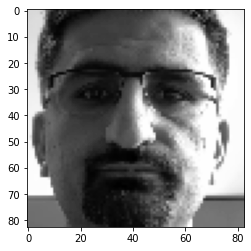

In [5]:
faces = face_cascade.detectMultiScale(resize_crop)[0]
face_crop = resize_crop[faces[1]:faces[1]+faces[3], faces[0]:faces[0]+faces[2]]
plt.imshow(face_crop, cmap="gray")

In [8]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

In [7]:
resize_crop = resize_crop.flatten()
scaled = scaler.fit_transform(resize_crop.reshape(-1, 1))
scaled = np.append(np.array([rank]), scaled).reshape(1, -1)
scaled

array([[0.        , 0.80952381, 0.81349206, ..., 0.26984127, 0.27380952,
        0.28571429]])

In [80]:
global df
df = pd.DataFrame()

In [35]:
def get_frame(sec):
    video.set(cv2.CAP_PROP_POS_MSEC, sec*1000)
    success, image = video.read()
    return success, image

In [11]:
def get_data(sec):
    global df
    success, image  = get_frame(sec)
    if not success:
        return
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    resized = cv2.resize(gray, (90, 160))
    scaled = scaler.fit_transform(resized).flatten()
    out = np.append(np.array([rank]), scaled).flatten()
    df = df.append(pd.Series(out), ignore_index=True)

In [3]:
def get_face(sec):
    global df
    success, image  = get_frame(sec)
    if not success:
        return
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    face_loc = face_cascade.detectMultiScale(gray, minSize=(50, 50))
    if len(face_loc) == 0:
        print("didnt find")
        return
    face_loc = sorted(face_loc, key=lambda x:x[2], reverse=True)
    face_crop = gray[face_loc[0][1]:face_loc[0][1]+face_loc[0][3], face_loc[0][0]:face_loc[0][0]+face_loc[0][2]]
    face_crop = cv2.resize(face_crop, (28, 28))
    scaled = scaler.fit_transform(face_crop).flatten()
    out = np.append(np.array([rank]), scaled).flatten()
    plt.imshow(face_crop, cmap="gray")
    df = df.append(pd.Series(out), ignore_index=True)

In [4]:
from mlxtend.image import extract_face_landmarks

In [81]:
def get_features(sec):
    global df
    success, image  = get_frame(sec)
    if not success:
        return
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    locations = extract_face_landmarks(gray)
    if not type(locations) == np.ndarray:
        print("didnt find")
        return
    out = get_features_measurements(locations)
    out = np.append(np.array([rank]), out).flatten()
    df = df.append(pd.Series(out), ignore_index=True)
    
#     plt.scatter(locations[:, 0], -locations[:, 1], alpha=0.8)
#     plt.scatter(locations[36:42, 0], -locations[36:42, 1], color="red") #left eye
#     plt.scatter(locations[39, 0], -locations[39, 1], color="purple")
#     plt.scatter(locations[42:48, 0], -locations[42:48, 1], color="orange") #right eye
#     plt.scatter(locations[48:60, 0], -locations[48:60, 1], color="green")
#     plt.show()

get_features(12)

In [77]:
def get_features_measurements(locations):
    left = locations[36:42, :]
    right = locations[42:48, :]
    mouth = locations[48:60, :]
    
    left = sorted(left, key=lambda x : x[0])
    left_width = left[-1][0] - left[0][0]
    left = sorted(left, key=lambda x : x[1])
    left_height = left[-1][1] - left[0][1]

    right = sorted(right, key=lambda x : x[0])
    right_width = right[-1][0] - right[0][0]
    right = sorted(right, key=lambda x : x[1])
    right_height = right[-1][1] - right[0][1]
    
    mouth = sorted(mouth, key=lambda x : x[0])
    mouth_width = mouth[-1][0] - mouth[0][0]
    mouth = sorted(mouth, key=lambda x : x[1])
    mouth_height = mouth[-1][1] - mouth[0][1]
    
    face = sorted(locations, key=lambda x : x[0])
    face_width = face[-1][0] - face[0][0]
    face = sorted(locations, key=lambda x : x[1])
    face_height = face[-1][1] - face[0][1]
 

    return [left_width/face_width, left_height/face_height, right_width/face_width, right_height/face_height, mouth_width/face_width, mouth_height/face_height]

In [28]:
for p in ["01", "02", "03", "04", "05", "06"]:
    for r in [0, 5, 10]:
        vid_name = p + "/" + str(r)
        rank = r
        video = cv2.VideoCapture(vid_name + ".MOV")
        success, _ = video.read()
        if not success:
            video = cv2.VideoCapture(vid_name + ".mp4")
        
        start = time.time()
        df = pd.DataFrame()
        for i in range(0, 600, 10):
            elapsed = time.time() - start
            done = (i+1)/600
            estimate = int(elapsed/done - elapsed)
            print(f"Currently at {i//60} minutes and {i%60} seconds -- Estimated {estimate}s left on {vid_name}        ", end="\r")

            get_data(i)

        df.to_csv("data/" + p + "-" + str(r) + ".csv", header=False, index=False)

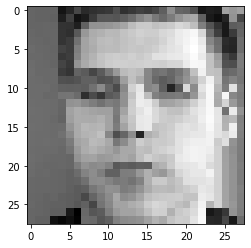

In [11]:
for p in ["01", "02", "03", "04", "05", "06", "19", "20", "21", "22", "23", "24"]:
    for r in [0, 10]:
        vid_name = p + "/" + str(r)
        rank = r
        video = cv2.VideoCapture(vid_name + ".MOV")
        success, _ = video.read()
        if not success:
            video = cv2.VideoCapture(vid_name + ".mp4")
        
        start = time.time()
        df = pd.DataFrame()
        for i in range(0, 600, 30):
            elapsed = time.time() - start
            done = (i+1)/600
            estimate = int(elapsed/done - elapsed)
            print(f"Currently at {i//60} minutes and {i%60} seconds -- Estimated {estimate}s left on {vid_name}        ", end="\r")

            get_face(i)

        df.to_csv("face data/" + p + "-" + str(r) + ".csv", header=False, index=False)

In [83]:
for p in ["01", "02", "03", "04", "05", "06", "19", "20", "21", "22", "23", "24"]:
    for r in [0, 10]:
        vid_name = p + "/" + str(r)
        rank = r
        video = cv2.VideoCapture(vid_name + ".MOV")
        success, _ = video.read()
        if not success:
            video = cv2.VideoCapture(vid_name + ".mp4")
        
        start = time.time()
        df = pd.DataFrame()
        for i in range(0, 601, 60):
            elapsed = time.time() - start
            done = (i+1)/600
            estimate = int(elapsed/done - elapsed)
            print(f"Currently at {i//60} minutes and {i%60} seconds -- Estimated {estimate}s left on {vid_name}        ", end="\r")

            get_features(i)

        df.to_csv("feature data/" + p + "-" + str(r) + ".csv", header=False, index=False)

c:\users\andre\appdata\local\programs\python\python38\lib\site-packages\mlxtend\image\extract_face_landmarks.py:66: UserWarning: No face detected.
  warnings.warn('No face detected.')


didnt find
didnt findat 2 minutes and 0 seconds -- Estimated 7s left on 05/10         
didnt findat 0 minutes and 0 seconds -- Estimated 0s left on 20/0          
didnt findat 1 minutes and 0 seconds -- Estimated 7s left on 23/0          
